In [1]:
import time
import arviz
import numpy as np
import pandas as pd
import scipy.special as sp
import scipy.stats as sts
import stan
import nest_asyncio
nest_asyncio.apply() 

In [2]:
# Parameters
P = [3, 5, 1, 4, 1, 2, 1, 1, 4]
N = 10 ** 4
ITER = 1000
WARMUP = 500
CHAINS = 8
SEED = 1729

In [3]:
#### GROUND TRUTH ####
np.random.seed(SEED)

# Mask-wearing
mask_wearer = np.random.binomial(1, 0.5, size=(N,))
true_mask_impact = np.random.lognormal(-1, 0.5, len(P))
true_mask_impact_rep = np.repeat(true_mask_impact, P)

# Test use
t_i = np.random.beta(8, 2, 1)  # Prob(tested | infected)
t_not_i = np.random.beta(2, 20, 1)  # Prob(tested | not-infected)
true_gamma = np.array([t_i, t_not_i])

# Test accuracy
test_sensitivity = np.random.beta(4, 3, 1)  # True positive rate
test_specificity = np.random.beta(50, 2, 1)  # True negative rate
true_lambda = np.array([test_sensitivity, test_specificity])

# Transmission rates
true_transmission_rate_mu = np.random.beta(2, 10, len(P))
true_transmission_rate_std = np.sqrt(sts.invgamma.rvs(a=100, size=len(P)))
true_transmission_rate = np.concatenate([
    sp.expit(sp.logit(mu) + np.random.normal(0, std, p))
    for p, mu, std
    in zip(P, true_transmission_rate_mu, true_transmission_rate_std)
])
base_rate = np.random.beta(2, 10, 1)

# Occurrence rates
true_occurrence_rate_mu = np.random.beta(2, 10, len(P))
true_occurrence_rate_std = np.sqrt(sts.invgamma.rvs(a=50, size=len(P)))
true_occurrence_rate = np.concatenate([
    sp.expit(sp.logit(mu) + np.random.normal(0, std, p))
    for p, mu, std
    in zip(P, true_occurrence_rate_mu, true_occurrence_rate_std)
])

# Set antigen test mean and std. error for TP and TN rates (for strong priors)

# True positive
mean_tp = 0.73000
se_tp = 0.04133

# True negative
mean_tn = 0.99680
se_tn = 0.00066

mean_rates = [mean_tp, mean_tn]
se_rates = [se_tp, se_tn]
alphas = []
betas = []

for i in range(2):
    alphas.append((((1 - mean_rates[i])/se_rates[i]**2)-(1/mean_rates[i])) * (mean_rates[i]**2))
    betas.append(alphas[i]*((1/mean_rates[i])-1))
    
print('Shape parameters for test accuracy priors:')    
print('Alphas: ', alphas)
print('Betas: ', betas)

prior_params = np.array([alphas, betas]).T
print(prior_params)

Shape parameters for test accuracy priors:
Alphas:  [83.50230278926166, 7298.251978696008]
Betas:  [30.88441336041184, 23.429380348943674]
[[  83.50230279   30.88441336]
 [7298.2519787    23.42938035]]


In [4]:
#### SIMULATE DATA ####
data = {}
for p in range(sum(P)):
    occurrence = np.random.binomial(1, true_occurrence_rate[p], N)
    # Impact of mask-wearing
    transmission_prob = sp.expit(sp.logit(true_transmission_rate[p]) +
                                 np.log(true_mask_impact_rep[p]) * mask_wearer)
    transmission = occurrence * np.random.binomial(1, transmission_prob)
    data[f'O{p+1}'] = occurrence
    data[f'T{p+1}'] = transmission

data['T0'] = np.random.binomial(1, base_rate, N)
X = pd.DataFrame(data)
z = X.loc[:, X.columns.str.startswith('T')].sum(axis=1)
y = (z > 0).astype(int)

# Resampling for test use
tested = y*np.random.binomial(1, true_gamma[0], N) + \
         (1-y)*np.random.binomial(1, true_gamma[1], N)
y = y[tested == 1]
X_survey = X[tested == 0].reset_index()
m_survey = mask_wearer[tested == 0]
X = X[tested == 1].reset_index()
m = mask_wearer[tested == 1]
X = X.loc[:, X.columns.str.startswith('O')]
X_survey = X_survey.loc[:, X_survey.columns.str.startswith('O')]
N = X.shape[0]
NA = X_survey.shape[0]

# Introduce false positives and negatives
y = y * np.random.binomial(1, true_lambda[0], N) + \
    (1-y) * np.random.binomial(1, (1-true_lambda[1]), N)

# Record classes
c = np.array([i + 1 for i, p in enumerate(P) for __ in range(p)])

In [5]:
# Stan model code
model_code = """
functions {
  real expit_gaussian_lpdf(real y, real logit_mu, real sigma2) {
    return log(1 / y + 1 / (1 - y)) - (logit(y) - logit_mu)^2 / (2 * sigma2);
  }
}
data {
  int<lower=0> N;                            // number of observations
  int<lower=0> NA;                           // number of survey observations
  int<lower=0> P;                            // number of places
  int<lower=0> K;                            // number of classes
  int<lower=0, upper=1> X[N,P];              // activity occurrences
  int<lower=0, upper=1> y[N];                // transmission (tested positive)
  int<lower=0, upper=1> survey[NA,P];        // activity occurrences of surveyed individuals
  real lambda_prior_params[2,2];             // Shape parameters for TP/TN test rate priors
  int<lower=1, upper=K> c[P];                // place classes
  int<lower=0, upper=1> m[N];                // masking-wearing
  int<lower=0, upper=1> m_survey[NA];        // masking-wearing
}
parameters {
  real<lower=0, upper=1> theta[P];           // transmission rates
  real<lower=0, upper=1> mu[K];              // class transmission means
  real<lower=0> sigma2[K];                   // class transmission variances
  real<lower=0, upper=1> gamma[2];           // Testing rates, given infected status [T|I , T|!I]
  real<lower=0, upper=1> lambda[2];          // True positive and true negative rates of tests [TP,TN]
  real<lower=0, upper=1> rho;                // underlying risk
  real iota[K];                              // intervention impacts (log)
}
transformed parameters {
  // Pre-computation for efficiency
  real log1m_theta[P] = log1m(theta);
  real log1m_theta_int[P];
  real log1m_rho = log1m(rho);
  real logit_mu[K] = logit(mu);
  real log_gamma[2];
  real log1m_gamma[2];
  real log_lambda[2];
  real log1m_lambda[2];

  for (p in 1:P) {
    log1m_theta_int[p] = log1m_inv_logit(logit(theta[p]) + iota[c[p]]);
  }

  for (p in 1:P) {
    log1m_theta[p] = log1m(theta[p]);
  }
  for(i in 1:2){
    log_gamma[i] = log(gamma[i]);
    log1m_gamma[i] = log1m(gamma[i]);
    log_lambda[i] = log(lambda[i]);
    log1m_lambda[i] = log1m(lambda[i]);
  }
}
model {
  // Priors
  mu ~ beta(1, 5);
  sigma2 ~ inv_gamma(10, 1);
  rho ~ beta(1, 3);
  iota ~ normal(-1, 1);
  gamma ~ uniform(0, 1);
  lambda[1] ~ beta(lambda_prior_params[1,1],lambda_prior_params[1,2]);
  lambda[2] ~ beta(lambda_prior_params[2,1],lambda_prior_params[2,2]);
  
  // Likelihood (classes)
  for (p in 1:P) {
    theta[p] ~ expit_gaussian(logit_mu[c[p]], sigma2[c[p]]);
  }
  // Likelihood (survey)
  for (n in 1:NA) {
    real s = 0.0;
    for (p in 1:P) {
      if (survey[n,p] == 1) {
        if (m_survey[n] == 1) {
          s += log1m_theta_int[p];
        } else {
          s += log1m_theta[p];
        }
      }
    }
    s += log1m_rho;
    target += log_sum_exp((log1m_exp(s)+log1m_gamma[1]), (s+log1m_gamma[2]));
  }
  // Likelihood (observations)
  for (n in 1:N) {
    real s = 0.0;
    for (p in 1:P) {
      if (X[n,p] == 1) {
        if (m[n] == 1) {
          s += log1m_theta_int[p];
        } else {
          s += log1m_theta[p];
        }
      }
    }
    s += log1m_rho;
    if (y[n] == 1) {
      target += log_sum_exp((log1m_exp(s) + log_gamma[1] + log_lambda[1]), (s + log_gamma[2] + log1m_lambda[2]));
    } else {
      target += log_sum_exp((s + log_gamma[2] + log_lambda[2]), (log1m_exp(s) + log_gamma[1] + log1m_lambda[1]));
    }
  }
}

""" 

In [6]:
#### SAMPLING ####
# Define model data
model_data = {
    'N': N, 'NA': NA, 'P': sum(P), 'K': len(P),
    'X': X.to_numpy(), 'y': y.to_numpy(), 'c': c, 'm': m, 'm_survey': m_survey,
    'survey': X_survey.to_numpy(), 'lambda_prior_params':prior_params,
}
# Compile model
posterior = stan.build(model_code, data=model_data, random_seed=1)

Building... This may take some time.
Messages from stanc:
  The parameter lambda has no priors.
  The parameter theta has no priors.
Done.


In [7]:
# Fit model
fit = posterior.sample(num_samples=ITER, num_warmup=WARMUP, num_chains=CHAINS)

Sampling...
     0/12000 [>---------------------------]   0%  1 sec/0     
     1/12000 [>---------------------------]   0%  1 sec/12702 
     1/12000 [>---------------------------]   0% 3 secs/26115 
     1/12000 [>---------------------------]   0% 4 secs/39139 
     1/12000 [>---------------------------]   0% 5 secs/51769 
     1/12000 [>---------------------------]   0% 6 secs/65675 
     1/12000 [>---------------------------]   0% 7 secs/79237 
     1/12000 [>---------------------------]   0% 8 secs/91624 
     1/12000 [>---------------------------]   0% 9 secs/104672
     1/12000 [>---------------------------]   0% 10 secs/117881
     1/12000 [>---------------------------]   0% 11 secs/131979
     1/12000 [>---------------------------]   0% 13 secs/145225
     1/12000 [>---------------------------]   0% 14 secs/157964
     1/12000 [>---------------------------]   0% 15 secs/171440
     1/12000 [>---------------------------]   0% 16 secs/185132
     1/12000 [>----------------------

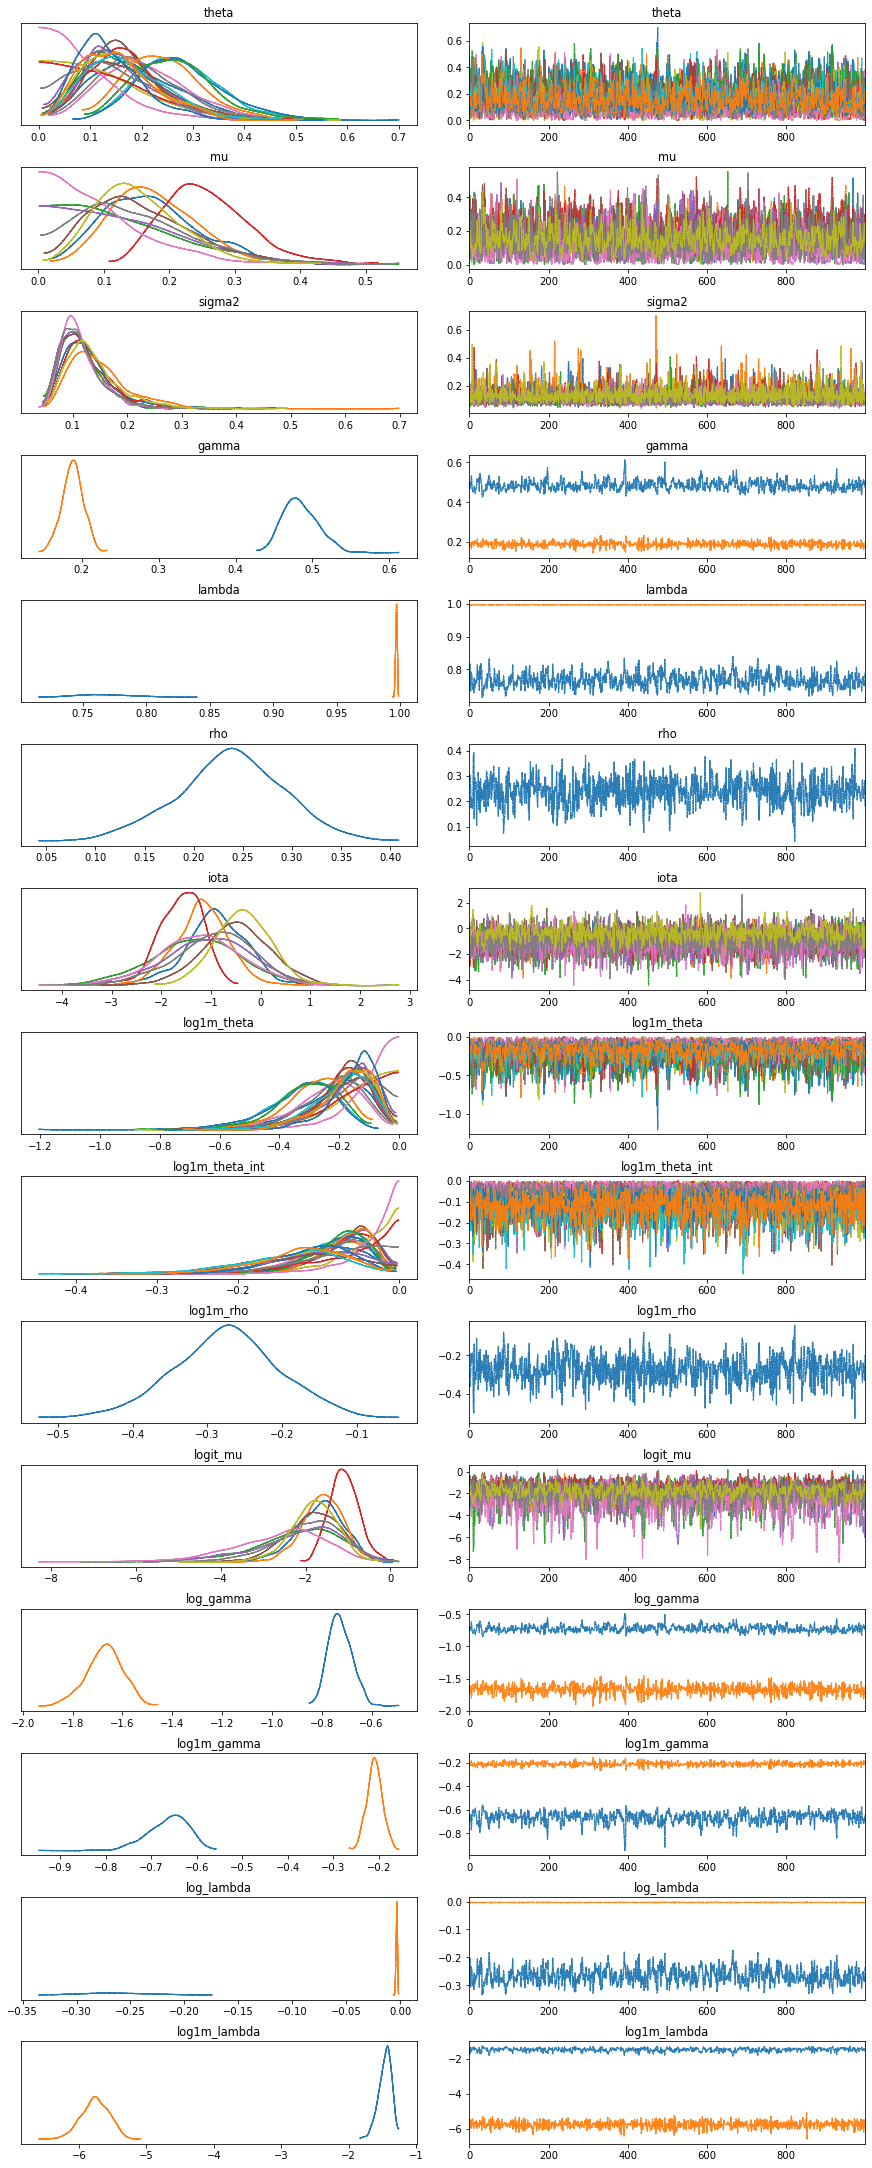

In [8]:
# Evaluate fit
arviz.plot_trace(fit);

In [9]:
# View model results summary
fit = fit.to_frame()
print("Inference on fitted model:")
fit.describe()

Inference on fitted model:


parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,theta.1,theta.2,theta.3,...,logit_mu.8,logit_mu.9,log_gamma.1,log_gamma.2,log1m_gamma.1,log1m_gamma.2,log_lambda.1,log_lambda.2,log1m_lambda.1,log1m_lambda.2
count,8000.000000,8000.000000,8.000000e+03,8000.000000,8000.000000,8000.0,8000.000000,8000.000000,8000.000000,8000.000000,...,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,-9175.030467,0.897194,1.344448e-01,5.008000,37.032000,0.0,9201.760949,0.193424,0.170039,0.163427,...,-1.980149,-1.803490,-0.724897,-1.671332,-0.664647,-0.209046,-0.265486,-0.003215,-1.461885,-5.762164
std,5.644975,0.096285,1.707075e-14,0.209622,13.660685,0.0,7.494588,0.088285,0.079548,0.076422,...,0.876343,0.557346,0.049008,0.074894,0.047973,0.017268,0.028379,0.000652,0.096395,0.205018
min,-9196.887596,0.437619,1.344448e-01,4.000000,15.000000,0.0,9181.077915,0.020901,0.021577,0.014854,...,-5.827987,-4.988524,-0.850209,-1.935175,-0.947669,-0.265097,-0.334955,-0.006203,-1.832826,-6.596843
25%,-9178.621330,0.849545,1.344448e-01,5.000000,31.000000,0.0,9196.277775,0.127977,0.114432,0.106853,...,-2.415705,-2.134910,-0.758901,-1.717191,-0.692448,-0.220067,-0.286024,-0.003660,-1.519242,-5.894394
50%,-9174.466436,0.925295,1.344448e-01,5.000000,31.000000,0.0,9201.400760,0.180758,0.157146,0.153334,...,-1.875746,-1.767728,-0.729167,-1.667815,-0.658380,-0.209067,-0.267423,-0.003154,-1.449658,-5.760568
75%,-9170.989920,0.973653,1.344448e-01,5.000000,31.000000,0.0,9206.577633,0.248738,0.210773,0.208998,...,-1.379426,-1.424163,-0.693847,-1.621841,-0.631451,-0.197926,-0.247024,-0.002759,-1.391286,-5.612253
max,-9161.001443,1.000000,1.344448e-01,6.000000,127.000000,0.0,9227.536181,0.529156,0.545485,0.463917,...,0.204198,-0.273730,-0.490441,-1.457282,-0.557438,-0.155951,-0.174307,-0.001366,-1.256567,-5.085758


In [10]:
# Comparison to ground truth
print('Ground truth:')
print('Theta: ', true_transmission_rate)
print('Mu', true_transmission_rate_mu)
print('Sigma', true_transmission_rate_std)
print('Rho', base_rate)
print('Iota', np.log(true_mask_impact))
print('Gamma', true_gamma)
print('Lambda', true_lambda)

Ground truth:
Theta:  [0.12538795 0.1295715  0.12770555 0.12189778 0.14173122 0.141376
 0.11633046 0.1404226  0.15918087 0.1267098  0.13387854 0.12902037
 0.14480578 0.03257836 0.11700522 0.1330922  0.10815501 0.06574576
 0.10576607 0.12462164 0.12161494 0.12050462]
Mu [0.11976386 0.13359646 0.14069448 0.13688617 0.03512384 0.13761168
 0.10133677 0.07502436 0.11887653]
Sigma [0.10162422 0.09729893 0.0940037  0.10310354 0.10567705 0.09157074
 0.10748543 0.10621232 0.10538793]
Rho [0.18387418]
Iota [-0.98094264 -1.10878889 -0.86430157 -1.39558018 -1.42325869 -0.03785362
 -0.91983802 -1.24557685 -0.52477118]
Gamma [[0.56399229]
 [0.18033559]]
Lambda [[0.80899594]
 [0.97921427]]
